In [1]:
!pip install -q pipreqsnb 
# this is needed to create the requirements.txt file

In [2]:
!pipreqsnb . --ignore bin,etc,include,lib,lib64 #--force
# this command creates the requirements.txt file

pipreqs  --ignore bin,etc,include,lib,lib64 .
INFO: Not scanning for jupyter notebooks.


In [3]:
!pip install -q -r requirements.txt 
# this command installs the dependencies contained in the requirements.txt file

# GKP states from vacuum

## Goal

We want to find circuits that map the vacuum to an approximate GKP state.

## Strategy

We can turn the optimization problem around: instead of starting from the vacuum and trying to unitarily drive it to the target state, we can start from the target state and try to find the unitary transformation $U(\vec{\lambda})$ that maximizes

$$\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2.$$ 

 
Our generated state, 

$$ \left|\Psi_g \right> = U(\vec{\lambda})^\dagger\left|0 \right> ,$$ 

is a good approximation of the target state when the fidelity,

$$ F = \left|\left<\Psi_g |\Psi_t \right>\right|^2 ,$$

is maximized.

## Code

In [1]:
# Importing necessary libraries
import strawberryfields as sf
sf.hbar = 1 # Setting convention for hbar
import numpy as np
import scipy
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [12]:
# Setting parameters

cutoff = 10 # Truncation of the Fock space
delta = 0.5 # Inverse width of Gaussian envelope

epsilon = delta**2 
# Strawberry Fields parameter epsilon which defines the Gaussian envelope in sf.ops.GKP

num_blocks = 6 # Number of repeated blocks of gates in circuit
num_trials = 2 # Number of repeated optimization trials
n_jobs = 2 # For parallelisation - best if this is a factor of num_trials


In [13]:
# Define a function for the action of the circuit on the input GKP state

def cooled_squared_vac_overlap(params, epsilon=epsilon, state = [0,0]): # note: state = [0,0] is |0>, [np.pi,0] is |1>
    '''
    Return the squared overlap with vacuum of the state resulting from application of 
    the parametrized circuit to the (given) approximate GKP state of given epsilon.

    The parametrized circuit consists of len(params)//4 blocks composed of:
        - 2 orthogonal displacements
        - one Kerr gate
        - one squeezing gate (with real squeezing parameter).

    The number of blocks is guessed from the size of the input parameters, assumed to be a multiple of 4.
    '''
    # Initialize Strawberry Fields program
    prog = sf.Program(1) # Photonic circuit with one mode
    with prog.context as q: 
        # Initialize state to be cooled down (target)
        sf.ops.GKP(epsilon=epsilon, state=state) | q 

        # Apply gates according to input parameters
        # Parameters are real numbers
        # The number of parameters is always a multiple of 4, since there are 4 parameters per block
        for j in range(len(params)//4):
            sf.ops.Xgate(params[4*j]) | q
            sf.ops.Zgate(params[4*j+1]) | q
            sf.ops.Kgate(params[4*j+2]) | q
            sf.ops.Sgate(params[4*j+3]/10.) | q
            # Squeezing is more sensitive to parameter shifts, so we compensate by dividing by a factor of 10

    # Initialize engine, selecting Fock backend
    eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff}) 

    # Execute program on engine
    cooled_state = eng.run(prog,shots=1).state # output state of parametrized circuit
    
    # Return fidelity with vacuum (negative for minimization later)
    return -cooled_state.fock_prob([0])

In [14]:
# Parallel trials for optimizing the gate parameters to maximize fidelity:

def OptimizeCircuit(trial_num):
    """
    Optimize gate parameters and maximize fidelity.

    Parameters:
    - trial_num (int): The index of the current trial.

    Returns:
    tuple: A tuple containing the fidelity with vacuum and the optimized gate parameters.

    Note:
    - The gate parameters are initialized with random values between 0 and 0.1.
    - The BFGS method is employed for optimization with a specified tolerance.
    """
    sf.hbar = 1
    result = scipy.optimize.minimize(cooled_squared_vac_overlap, 0.1*np.random.rand(num_blocks*4), method="BFGS", tol=1e-7)
    return -result['fun'], result['x'] 
    # 'fun' is the function being minimized, i.e. negative of fidelity
    # Extra minus sign ensures that the positive fidelity is returned
    # 'x' is the gate parameters

# Perform parallel optimization trials
FidsSols = Parallel(n_jobs=n_jobs)(delayed(OptimizeCircuit)(trial_num) for trial_num in range(num_trials))
FSarray=np.array(FidsSols,dtype=object) # Fidelities and solutions (gate parameters in circuit)
Fids=FSarray[:,0]
print('Fidelities = ',Fids) # Fidelities
bestFid=np.max(Fids) # Highest fidelity
print('Best fidelity = ',bestFid)
IndexOfMaxFid=np.argmax(Fids)
Sols=FSarray[:,1] # Gate parameters
bestSolution=Sols[IndexOfMaxFid]
# Best gate parameters, i.e. those that lead to the highest fidelity:
print('Best gate parameters = ',bestSolution) 
# Save the best parameters
np.savetxt('BestSol.out',bestSolution)

Fidelities =  [0.9868432843349385 0.9335129511674722]
Best fidelity =  0.9868432843349385
Best gate parameters =  [ 0.07515845 -0.16706219 -0.08909738 -0.62054188 -0.0537879   0.1385266
  0.00479933 -2.5445837   0.39046569  0.26582771  0.22054147  0.91011324
  0.0998308   0.17272147  0.29947536  0.70211617  0.35855859 -0.49253241
  0.47134617  3.09076136 -0.65836495 -0.47423134 -0.09029358  3.12035377]


### Check that the circuit prepares a GKP state

We now prepare the states from vacuum, by applying the adjoints of the optimized circuits found above. We check their fidelity with the target GKP state.  
 

In [15]:
def prepare_state(params):
    """
    Return the quantum state resulting from the application of the parametrized circuit *in reverse* to the vacuum.

    Parameters:
    - params (array): An array of real numbers representing the parameters for the gates of the circuit.

    Returns:
    BaseFockState: The output quantum state, in the Fock basis.
    """
    progParamState = sf.Program(1) # Photonic circuit with one mode
    with progParamState.context as q: 
        sf.ops.Vacuum() | q # Initialize vacuum
        rev_pars = np.flip(params) # Reverse the order of the gate parameters
        for j in range(len(params)//4): # Circuit in reverse:
            sf.ops.Sgate(-rev_pars[4*j]/10.) | q 
            sf.ops.Kgate(-rev_pars[4*j+1]) | q
            sf.ops.Zgate(-rev_pars[4*j+2]) | q
            sf.ops.Xgate(-rev_pars[4*j+3]) | q
    
    # Initialize engine, selecting Fock backend
    eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff})

    # Output state of parametrized circuit
    prepared_state = eng.run(progParamState,shots=1).state 

    return prepared_state

# A program to prepare the target state, so that we can compare with our generated state
progTarget= sf.Program(1) # Photonic circuit with one mode
with progTarget.context as q: 
    # Initialize target state
    # NB this has to match the state used in the previous optimization
    sf.ops.GKP( epsilon=epsilon, state=[0,0]) | q 
    
eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff}) # Initialize engine, selecting Fock backend
target_GKP = eng.run(progTarget,shots=1).state.ket() # Our target state
np.savetxt('TargetStateKet.out', target_GKP) # Save the Fock amplitudes of the target state
print(target_GKP)

[ 8.57088484e-01+0.j  1.34940381e-21+0.j -3.33213282e-01+0.j
  2.66975865e-19+0.j  3.08244043e-01+0.j -7.22325355e-19+0.j
  9.28254283e-02+0.j  3.03719078e-18+0.j  2.25249392e-01+0.j
 -1.40458198e-18+0.j]


In [16]:
# Reset engine 
if eng.run_progs:
    eng.reset()

# Use best parameters to prepare generated state from vacuum
generated_GKP = prepare_state(bestSolution).ket()
np.savetxt('GeneratedStateKet.out',generated_GKP)

# Calculate fidelity between generated state and target state
fid=np.abs(np.dot(generated_GKP.conj(), target_GKP))**2
print(f'Fidelity (abs squared overlap) with {len(bestSolution)//4} parametrized blocks: {fid}')

print(f'The fidelity above should match (or be very close to) the best fidelity from optimization: {bestFid}')

# Check normalization of target and generated state to ensure no leakage to Fock components higher than the cutoff
normgen=np.dot(generated_GKP.conj(), generated_GKP)
normtarg=np.dot(target_GKP.conj(), target_GKP)
print(f'This should be one if the state we prepared is normalized: {normgen}')
print(f'This should be one if the target GKP state is normalized: {normtarg}')

Fidelity (abs squared overlap) with 6 parametrized blocks: 0.9868432843349387
The fidelity above should match (or be very close to) the best fidelity from optimization: 0.9868432843349385
This should be one if the state we prepared is normalized: (0.9915115597160689+0j)
This should be one if the target GKP state is normalized: (1+0j)


### Wavefunction of target and generated states

We find the wavefunction in position, 
$$\Psi(q)=\left< q \,|\, \Psi_g \right>=\sum_n \left< q\,|\,n \right>\left< n\,|\,\Psi_g \right>,$$ 
from the Fock amplitudes of our generated state, $\left< n\,|\,\Psi_g \right>$. Here $\left< q \,|\, n \right>$ are Hermite functions,
$$\left< q \,|\, n \right> = \frac{e^{-\frac{1}{2}q^2}H_n(q)}{\sqrt{n!\,2^n\sqrt{\pi}}} ,$$
and $H_n(q)$ are Hermite polynomials.


We calculate $\frac{1}{\sqrt{2^n}}$ via recurrence relation:

In [17]:
def f(n):
    """
    Recursively calculates the value of f(n) = 1/sqrt(2**n).

    Parameters:
    - n (int): The input integer.

    Returns:
    float: The calculated value of f(n).
    """
    if n==0:
        return 1
    
    else:
        return (1/np.sqrt(2))*f(n-1)

We can also calculate $\sqrt{n!}$ recursively, by defining
$\\
g(n)=0 \;\; \text{for} \;\; n=0$  
$g(n)=\sum_n \ln(n) \;\; \text{for} \;\; 1\leq n \leq \mathrm{cutoff}$.

Then $\exp(g(n)/2)=\sqrt{n!}$ .

In [18]:
def g(n):
    """
    Recursively calculates the value of g(n)=ln(n!), so that exp(g(n)/2)=sqrt(n!).

    Parameters:
    - n (int): The input integer.

    Returns:
    float: The calculated value of g(n).
    """
    if n==0:    
        return 0
    
    else:
        return g(n-1)+np.log(n)

We can then calculate the wavefunction using $f(n)$ and $g(n)$:

In [19]:
def wavefunction(q, ket):
    """
    Compute the wavefunction in position space from the quantum state vector in the Fock basis.

    Parameters:
    - q (array): An array of position values.
    - ket (array): Fock-basis representation of the quantum state.

    Returns:
    array: Wavefunction in position basis.
    """
    c = ket.shape[0]
    coefficients=np.zeros(c,dtype=complex)

    # Calculating the coefficients (that depend on n) of each Hermite polynomial
    # i.e. coefficients[n] = <n|Psi_g>(n! 2**n)**(-1/2)
    for n in range(0,c):
        coefficients[n] = ket[n]*f(n)*np.exp(-g(n)/2)

    # Calculating the wavefunction, Psi(q):
    y = np.exp(-q ** 2 / 2)*np.pi**(-1/4) * np.polynomial.hermite.hermval(q, coefficients)
    
    return y

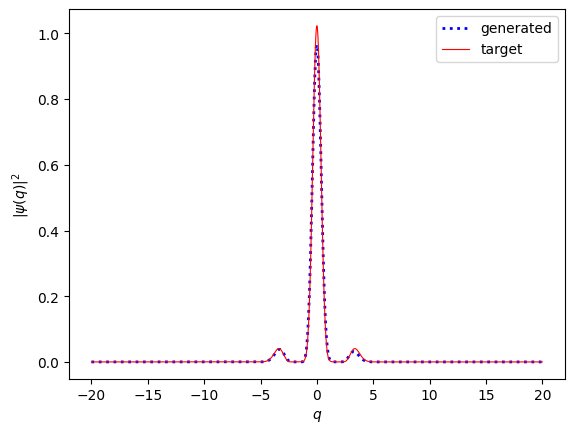

In [20]:
# Plot probability distribution of generated and target GKP states

qlim=20 # q-axis goes from -qlim to +qlim
genGKPwf=wavefunction(q=np.linspace(-qlim,qlim,1000), ket=generated_GKP)
targetGKPwf=wavefunction(q=np.linspace(-qlim,qlim,1000), ket=target_GKP)
plt.plot(np.linspace(-qlim,qlim,1000),np.real(genGKPwf*genGKPwf.conj()),label='generated',linestyle='dotted',color='b',linewidth=2)
plt.plot(np.linspace(-qlim,qlim,1000),np.real(targetGKPwf*targetGKPwf.conj()),label='target',color='r',linewidth=0.8)
plt.legend()
plt.ylabel("$|\psi(q)|^2$")
plt.xlabel("$q$");
#plt.savefig('ProbDists.png', bbox_inches='tight')

### Glancy-Knill error probability

Calculating the probability of no uncorrectable errors, $P(\text{no error})$, \
from Glancy & Knill (https://journals.aps.org/pra/abstract/10.1103/PhysRevA.73.012325), \
using Eq.(71) from Tzitrin et al. (https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.032315).

$$P(\text{no error})=\frac{1}{3}\sum_{s,t}\text{sinc}\left(\frac{t}{3}\right)\int_{\sqrt{\pi}\left(2s-\frac{1}{6}\right)}^{\sqrt{\pi}\left(2s+\frac{1}{6}\right)}du\, \Psi^*(2t\sqrt{\pi}+u)\Psi(u),$$

where $\text{sinc}$ is the normalized function, $\text{sinc}(x)=(\sin{\pi x})/(\pi x)$. 

The error probability is then simply $P(\text{error})=1-P(\text{no error})$.

In [11]:
n=30 # No. of strips in integration
size=30 # Infinite sums over  s and t are truncated to go from -size to +size

# Matrix to store values of P_{no error} for different values of s and t, before we take the sum
beforesum = np.zeros((2*size,2*size),dtype=complex) 
    
for t in range(-size,size):
    for s in range(-size,size):
        x=np.linspace((np.sqrt(np.pi))*(2*s-1/6),(np.sqrt(np.pi))*(2*s+1/6),n) # Position axis
        
        # Filling the matrix
        beforesum[t+size,s+size] =(1/3)*np.sinc(t/3)*np.trapz(np.conj \
        (wavefunction(x+2*t*np.sqrt(np.pi),generated_GKP))*wavefunction(x,generated_GKP),x)
            
p_noerror=np.sum(np.sum(beforesum,axis=0),axis=0) # Summing over s and t
p_error=1-p_noerror # Calculate error probability from no-error probability
print("P(error)=",p_error)

P(error)= (0.6947445627004978-1.5178830414797062e-18j)


To achieve lower error probabilities, we need to decrease delta whilst maintaining a high fidelity.